### HW_lesson_4

#### Задание 1.
В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np
from sklearn import model_selection
from sklearn.model_selection import train_test_split

In [2]:
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2,
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=42)

In [3]:
classification_data, classification_labels = datasets.make_classification(
                                                            n_samples=1000, n_features=2, n_informative=2, 
                                                            n_classes=2, n_redundant=0,
                                                            n_clusters_per_class=1, random_state=33)

In [4]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

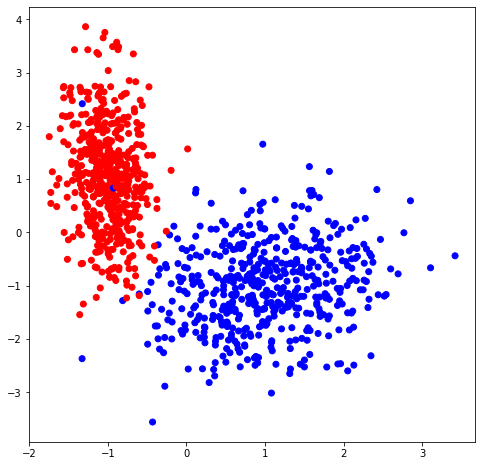

In [5]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [6]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [7]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [8]:
class Descision_Tree:
    
    def __init__(self, min_leaf, metric_):
        
        self.q_metric = metric_
        self.min_leaf = min_leaf
                      
    def quality_metrics(self, labels):

        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критериев
        entropy_ = 0
        impurity = 1    
        for label in classes:
            p = classes[label] / len(labels)
            if p != 0:
                entropy_ -= p * np.log2(p)
            else:
                entropy_ -= 0
                
            impurity -= p ** 2    

        if self.q_metric == 'gini':
            return impurity

        elif self.q_metric == 'entropy':
            return entropy_
              
    # Расчет качества
    def quality(self, left_labels, right_labels, metric_):        
        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        return metric_ - p * self.quality_metrics(left_labels) - (1 - p) * self.quality_metrics(right_labels)         
              
    # Разбиение датасета в узле
    def split(self, data, labels, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]
        return true_data, false_data, true_labels, false_labels        
        
    # Нахождение наилучшего разбиения
    def find_best_split(self, data, labels):

        current_metric = self.quality_metrics(labels)

        best_quality = 0
        best_t = None
        best_index = None
        
        #min_leaf = 5 записали его параметром класса
        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее параметра min_leaf
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_metric)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_metric, t, index                    
        return best_quality, best_t, best_index        
   
    # Построение дерева с помощью рекурсивной функции
    # добавлен критерий останова - max_debth

    def build_tree(self, data, labels, max_depth = 3):

        quality, t, index = self.find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0 or max_depth == 0:
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels, max_depth - 1)
        false_branch = self.build_tree(false_data, false_labels, max_depth - 1)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)
    
    
    def fitting_tree(self, data, labels):
        self.tree_ = self.build_tree(data, labels)
        
    
    def classify_object(self, obj, node):
        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
                
    def predict(self, data):        
        classes = []
        for obj in data:
            prediction = self.classify_object(obj, self.tree_)        
            classes.append(prediction)
        return classes

In [9]:
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [10]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

#### Задание 2.
Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.

In [11]:
t1 = Descision_Tree(min_leaf = 50, metric_ = 'gini') 
t1.fitting_tree(train_data, train_labels)

train_answers1 = t1.predict(train_data)

test_answers1 = t1.predict(test_data)

In [12]:
train_accuracy1 = accuracy_metric(train_labels, train_answers1)
train_accuracy1

70.71428571428572

In [13]:
test_accuracy1 = accuracy_metric(test_labels, test_answers1)
test_accuracy1

72.33333333333334

In [14]:
t2 = Descision_Tree(min_leaf = 50, metric_ = 'entropy') 
t2.fitting_tree(train_data, train_labels)

train_answers2 = t2.predict(train_data)

test_answers2 = t2.predict(test_data)

In [15]:
train_accuracy2 = accuracy_metric(train_labels, train_answers2)
train_accuracy2

70.71428571428572

In [16]:
test_accuracy2 = accuracy_metric(test_labels, test_answers2)
test_accuracy2

72.33333333333334